In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates

### Part 1- preprocessing:

In [3]:
file_path = "International_Report_Departures.csv"
df = pd.read_csv(file_path)
display(df) #visualisation without aggregation

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,05/01/2006,2006,5,12016,GUM,5,13162,MAJ,844,20177,PFQ,1,Departures,0,10,10
1,05/01/2003,2003,5,10299,ANC,1,13856,OKO,736,20007,5Y,1,Departures,0,15,15
2,03/01/2007,2007,3,10721,BOS,13,12651,KEF,439,20402,GL,1,Departures,0,1,1
3,12/01/2004,2004,12,11259,DAL,74,16271,YYZ,936,20201,AMQ,1,Departures,0,1,1
4,05/01/2009,2009,5,13303,MIA,33,11075,CMW,219,21323,5L,0,Departures,0,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930803,07/01/2000,2000,7,13303,MIA,33,13605,NAS,204,20398,MQ,1,Departures,1422,0,1422
930804,04/01/2019,2019,4,13303,MIA,33,14286,PTY,162,19770,CM,0,Departures,1439,0,1439
930805,08/01/2000,2000,8,13303,MIA,33,13605,NAS,204,20398,MQ,1,Departures,1441,0,1441
930806,09/01/2004,2004,9,12266,IAH,74,15632,VSA,148,19534,AM,0,Departures,1461,0,1461


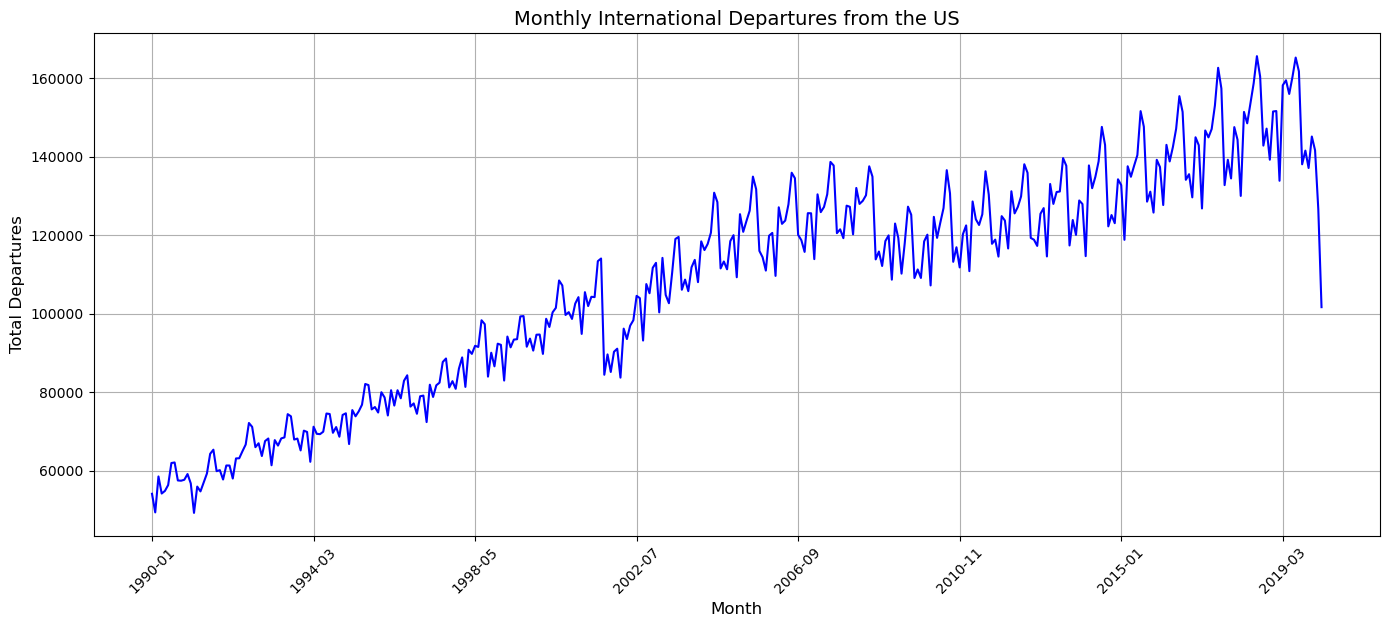

In [4]:
# Convert date column to datetime
df['data_dte'] = pd.to_datetime(df['data_dte'])

# Create a year-month column
df['year_month'] = df['data_dte'].dt.to_period('M')

# Aggregate by month: sum total departures
monthly_departures = df.groupby('year_month')['Total'].sum()

# Convert the index to string for readable axis labels
monthly_departures.index = monthly_departures.index.astype(str)

# Plotting the graph
plt.figure(figsize=(14, 6))
monthly_departures.plot(color='blue')
plt.title("Monthly International Departures from the US", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Departures", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [5]:
print(monthly_departures.isna().sum())        # count NaNs
print(monthly_departures.index.is_unique)     # does the dates are unique?
monthly_departures

0
True


year_month
1990-01     54129
1990-02     49391
1990-03     58542
1990-04     54195
1990-05     54863
            ...  
2019-11    137130
2019-12    145140
2020-01    141636
2020-02    126629
2020-03    101676
Name: Total, Length: 363, dtype: int64

To improve model stability and interpretability, we scaled down the number of monthly departures by a constant factor. Working with extremely large values can introduce numerical instability or affect model sensitivity. In addition, we excluded all data points after December 2019, since the COVID-19 pandemic significantly disrupted air travel patterns. Including this period would introduce an abrupt shift in the trend with no recovery data afterward, making it difficult for the model to learn meaningful patterns and forecast accurately.



In [7]:
monthly_departures = monthly_departures[monthly_departures.index <= '2019-12']
monthly_departures = monthly_departures / 1000
monthly_departures

year_month
1990-01     54.129
1990-02     49.391
1990-03     58.542
1990-04     54.195
1990-05     54.863
            ...   
2019-08    161.743
2019-09    138.071
2019-10    141.560
2019-11    137.130
2019-12    145.140
Name: Total, Length: 360, dtype: float64

Text(0, 0.5, 'Total Departures')

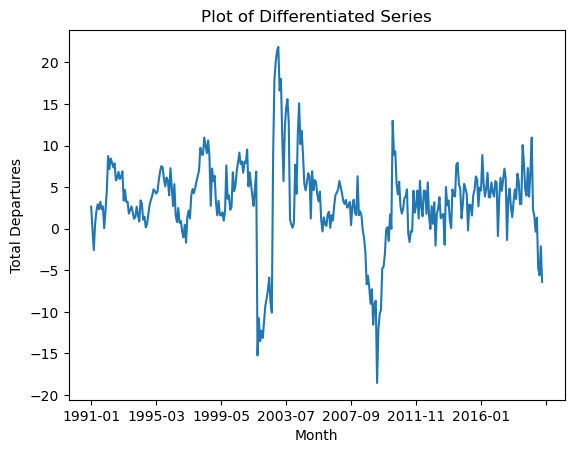

In [8]:
#Substract seasonality by using differncing
data_without_seasonality = monthly_departures.diff(periods=12)
data_without_seasonality = data_without_seasonality.dropna()
#Plot the transformed data
data_without_seasonality.plot()
plt.title("Plot of Differentiated Series")
plt.xlabel("Month")
plt.ylabel("Total Departures")

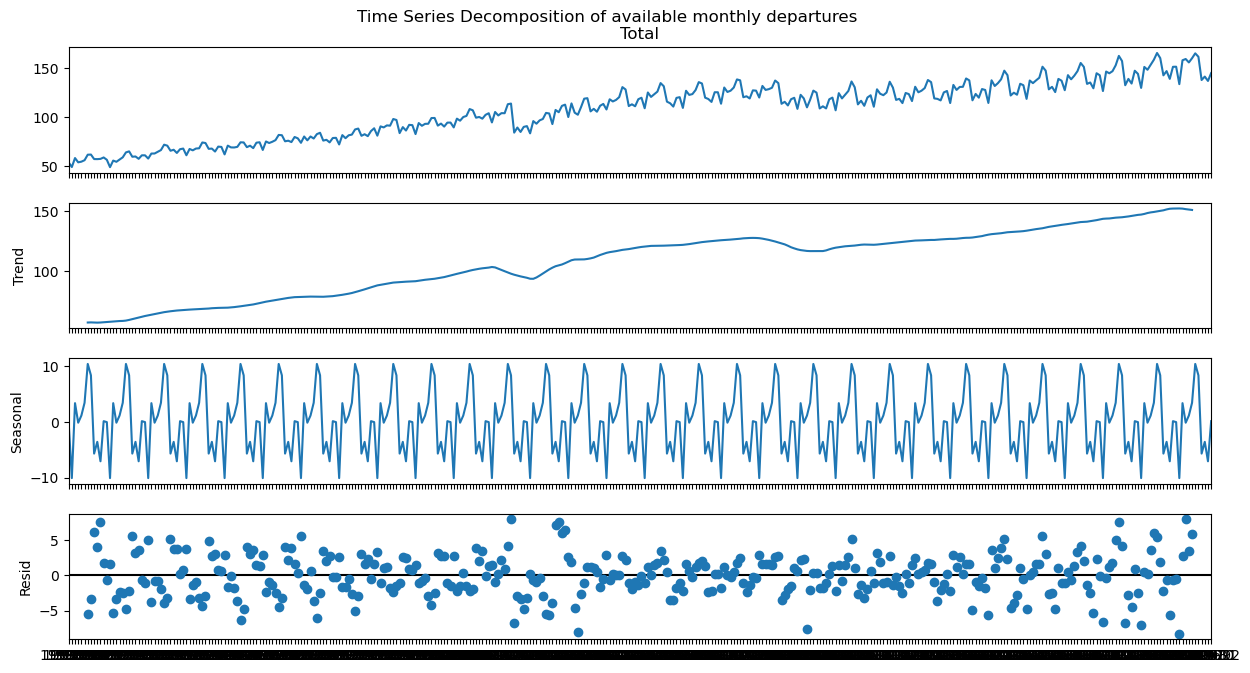

In [9]:
# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(monthly_departures, model='additive', period=12)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.suptitle('Time Series Decomposition of available monthly departures')
plt.show()

### Part 2

### Sarima models:

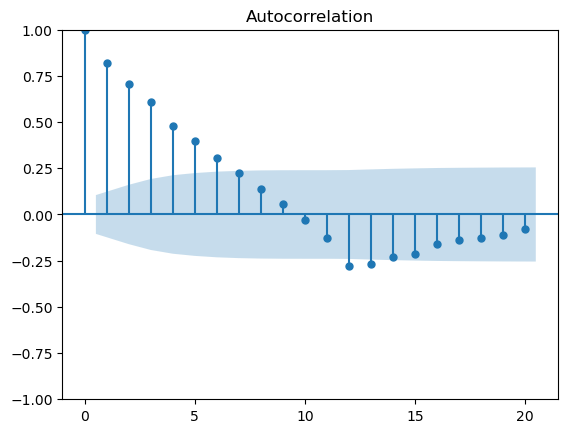

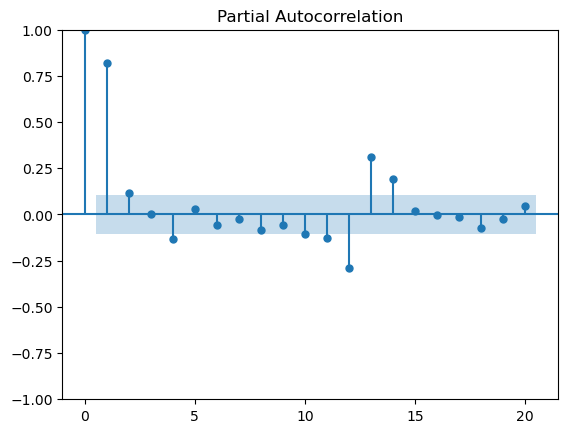

In [12]:
#Plotting the autocorrelation for the new series
tsaplots.plot_acf(data_without_seasonality, lags=20)
tsaplots.plot_pacf(data_without_seasonality, lags=20)
plt.show()

The model looks like AR(1) or equivalent to SARIMA(1,0,0)(0,1,0)_12. That because the Autocorrelation gradually decreases over time in a geometric decay pattern, which is typical for an AR(1) process. Also Partial Autocorrelation shows a spike at lag 2 and then cuts off sharply, so AR(2) is more likely. Another option is SARIMA(1,0,0)(1,1,0)_12 because the PACF acts like the AR's PACF. Also we can see a peak at t=11 and 12, that implies that maybe there is also AR seasonality.
In conclusion we will check: SARIMA(p,0,0)(0,1,0)_12 and SARIMA(p,0,0)(1,1,0)_12 for p=1,2


In [14]:
#SARIMA(1,0,0)(0,1,0)_{s=12}
model_AR1 = SARIMAX(monthly_departures, order=(1,0,0), seasonal_order=(0,1,0,12))
model_AR1 = model_AR1.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
#SARIMA(1,0,0)(1,1,0)_{s=12}
model_AR1s = SARIMAX(monthly_departures, order=(1,0,0), seasonal_order=(1,1,0,12))
model_AR1s = model_AR1s.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
#SARIMA(2,0,0)(0,1,0)_{s=12}
model_AR2 = SARIMAX(monthly_departures, order=(2,0,0), seasonal_order=(0,1,0,12))
model_AR2 = model_AR2.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [17]:
#SARIMA(2,0,0)(1,1,0)_{s=12}
model_AR2s = SARIMAX(monthly_departures, order=(2,0,0), seasonal_order=(1,1,0,12))
model_AR2s = model_AR2s.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [18]:
#Check the models BICs
print(f'Model AR1 BIC is : {model_AR1.bic}')
print(f'Model AR1s BIC is : {model_AR1s.bic}')
print(f'Model AR2 BIC is : {model_AR2.bic}')
print(f'Model AR2s BIC is : {model_AR2s.bic}')

Model AR1 BIC is : 1776.1815708396514
Model AR1s BIC is : 1705.5624254589086
Model AR2 BIC is : 1775.7336733704471
Model AR2s BIC is : 1695.6211018842894


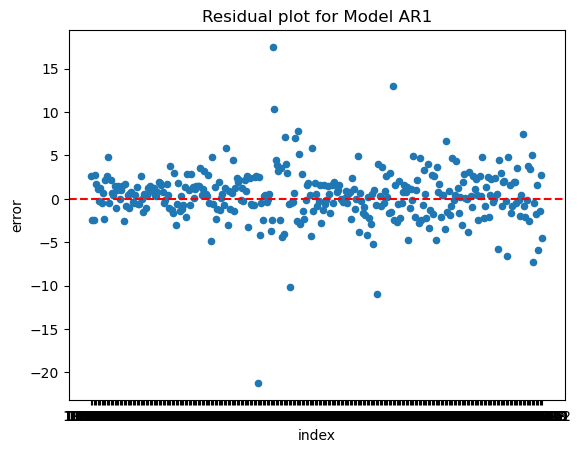

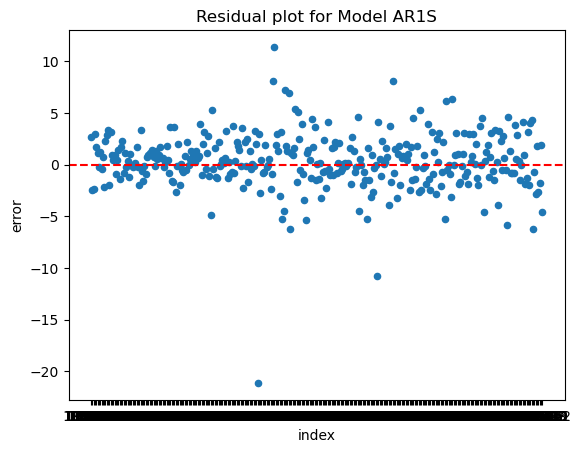

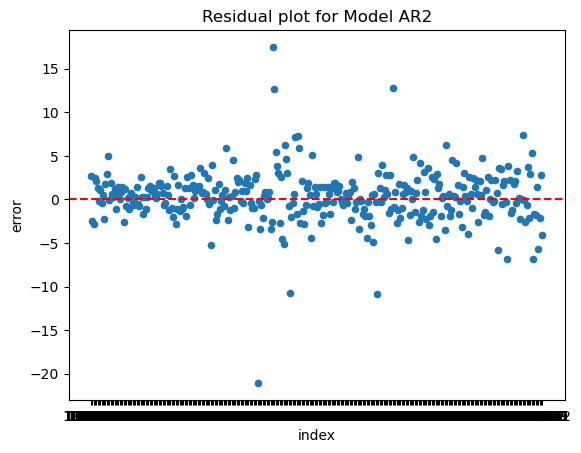

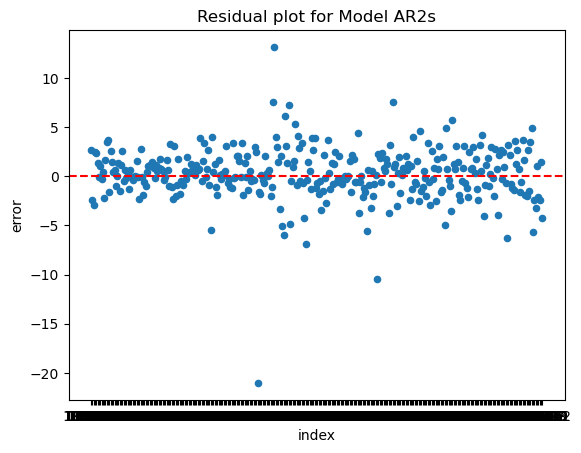

In [19]:
#Plot residual plots for every model


#Model AR1
res_plot = pd.DataFrame(model_AR1.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR1")
plt.show()

#Model AR1S
res_plot = pd.DataFrame(model_AR1s.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR1S")
plt.show()

#Model AR2
res_plot = pd.DataFrame(model_AR2.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR2")
plt.show()

#Model AR2s
res_plot = pd.DataFrame(model_AR2s.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR2s")
plt.show()

As we can see, the fourth model SARIMA(2,0,0)(1,1,0)_{s=12} , is a better fit and it has a lower BIC.All the models have pretty much the same residuals , so we will choose SARIMA(2,0,0)(1,1,0)_{s=12} as the best model.

In [21]:
print(model_AR2s.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Total   No. Observations:                  360
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -836.106
Date:                            Tue, 01 Apr 2025   AIC                           1680.212
Time:                                    20:52:31   BIC                           1695.621
Sample:                                01-01-1990   HQIC                          1686.347
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7257      0.043     16.846      0.000       0.641       0.810
ar.L2          0.2128      0.043   

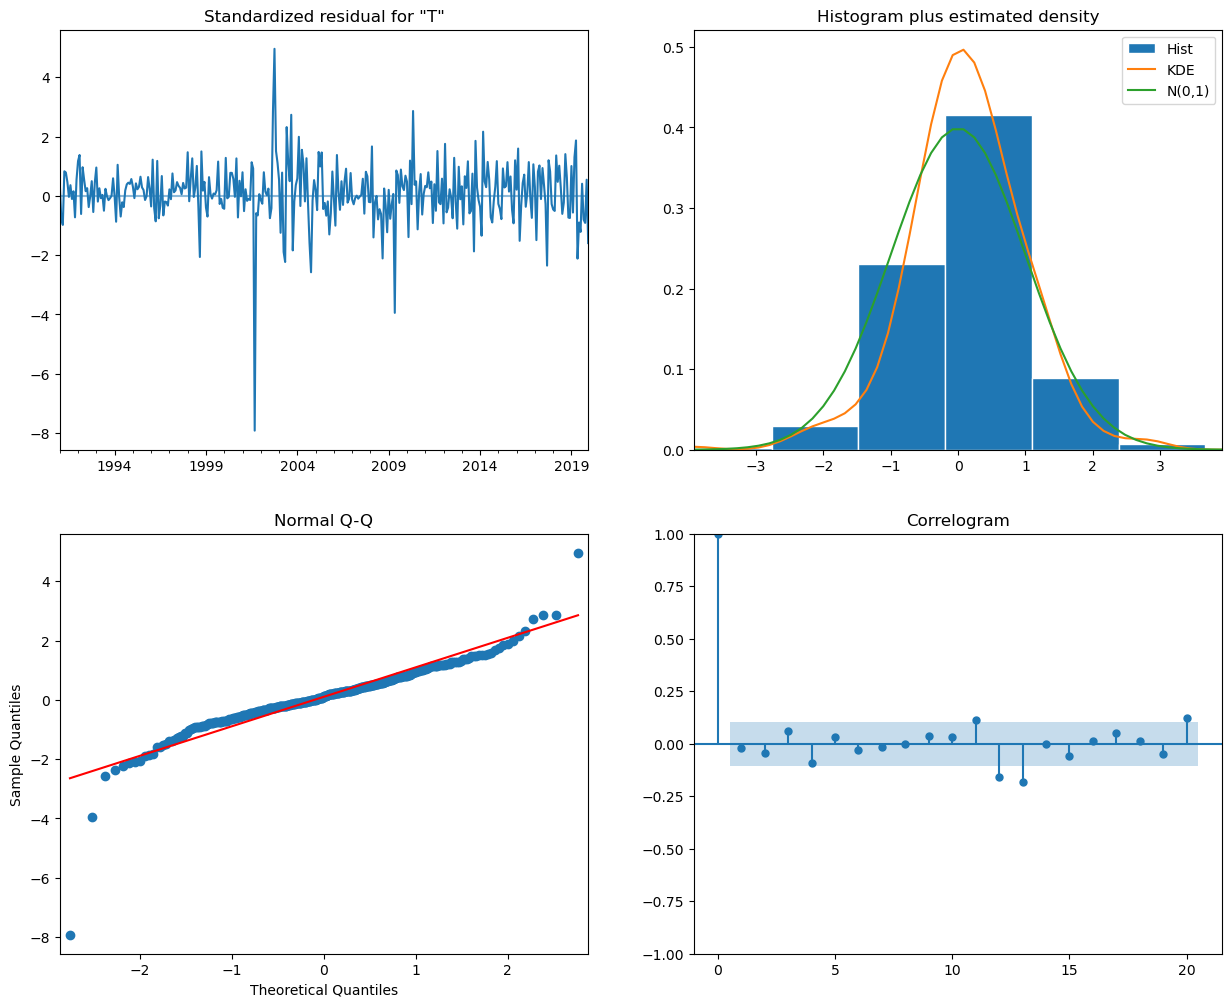

In [22]:
#Plot diagnostics
model_AR2s.plot_diagnostics(lags=20,figsize=(15, 12))
plt.show()

It's a good fit because in the QQ plot the dots  align with the line. Also, in the histogram the KDE fit very well the normal distrebution. 

In [24]:
# Forecast 60 steps ahead
forecast_steps = 60
forecast_result = model_AR2s.get_forecast(steps=forecast_steps)

# Get predicted mean and confidence intervals
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

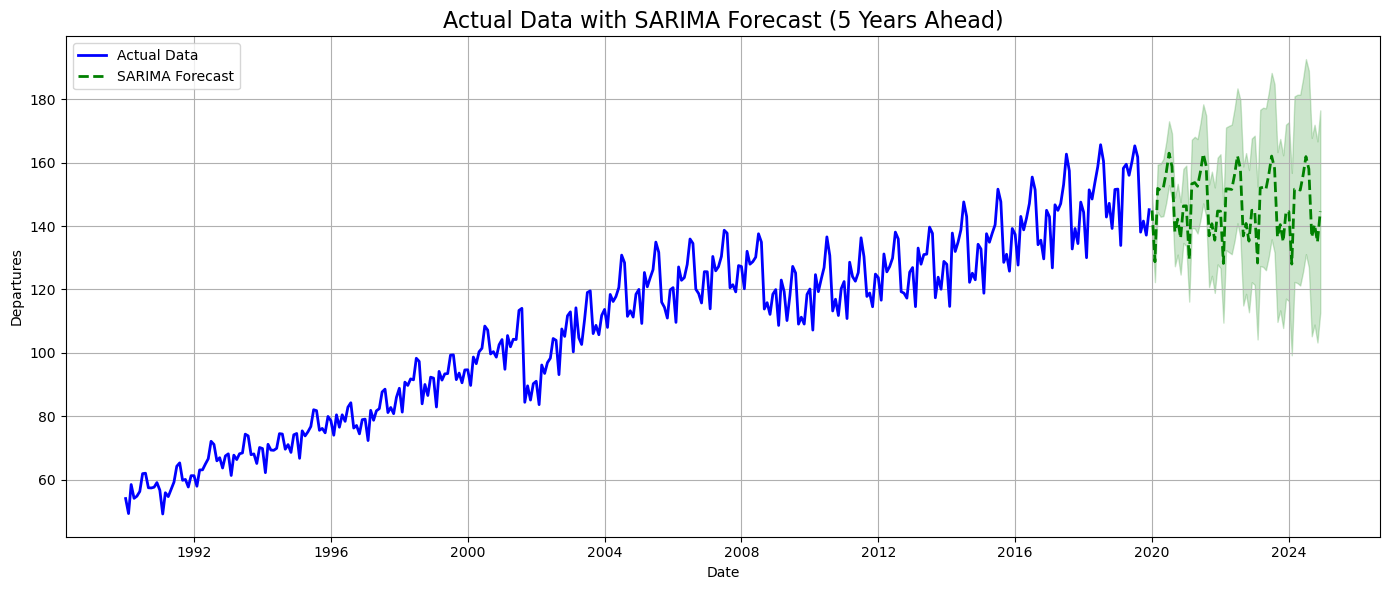

In [25]:
plt.figure(figsize=(14, 6))
monthly_departures.index = pd.to_datetime(monthly_departures.index)

# Plot actual data
plt.plot(monthly_departures, label='Actual Data', color='blue', linewidth=2)

# Plot forecast
forecast_index = pd.date_range(start=monthly_departures.index[-1] + pd.offsets.MonthBegin(1), 
                               periods=forecast_steps, freq='MS')

plt.plot(forecast_index, forecast_mean, label='SARIMA Forecast', color='green', linestyle='--', linewidth=2)

# Confidence interval
plt.fill_between(forecast_index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='green', alpha=0.2)

# Labels
plt.title('Actual Data with SARIMA Forecast (5 Years Ahead)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Departures')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Propthet model:

In [27]:
df_prophet = monthly_departures.reset_index()
df_prophet.columns = ['ds', 'y']

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

print(df_prophet.head())

          ds       y
0 1990-01-01  54.129
1 1990-02-01  49.391
2 1990-03-01  58.542
3 1990-04-01  54.195
4 1990-05-01  54.863


In [28]:
model_p = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
model_p.fit(df_prophet)

20:52:33 - cmdstanpy - INFO - Chain [1] start processing
20:52:33 - cmdstanpy - INFO - Chain [1] done processing


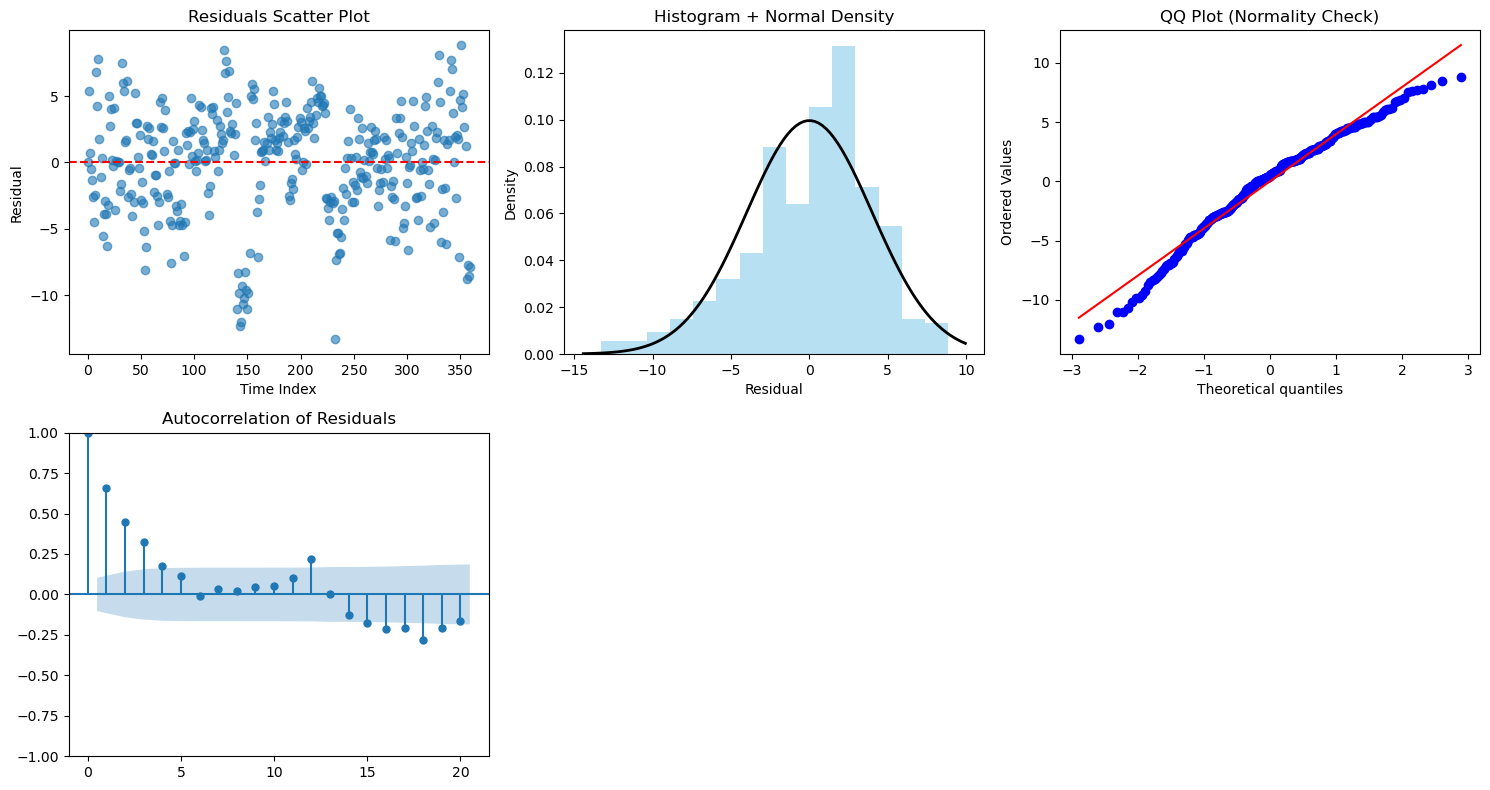

In [29]:
#Create residuals between actual and predicted values
actual = monthly_departures.values
future_df = model_p.make_future_dataframe(periods=365)
forecast_df = model_p.predict(future_df)
predicted = forecast_df['yhat'].iloc[:len(actual)].values
residuals = actual - predicted

#Plot diagnostics
plt.figure(figsize=(15, 8))

# Plot 1: Residuals scatter plot
plt.subplot(231)
plt.scatter(range(len(residuals)), residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Scatter Plot')
plt.xlabel('Time Index')
plt.ylabel('Residual')

# Plot 2: Histogram with normal distribution overlay
plt.subplot(232)
plt.hist(residuals, bins=15, density=True, alpha=0.6, color='skyblue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, pdf, 'k', linewidth=2)
plt.title('Histogram + Normal Density')
plt.xlabel('Residual')
plt.ylabel('Density')

# Plot 3: QQ Plot to check normality
plt.subplot(233)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot (Normality Check)')

# Plot 4: Autocorrelation of residuals
plt.subplot(234)
plot_acf(residuals, ax=plt.gca(), lags=20)
plt.title('Autocorrelation of Residuals')

plt.tight_layout()
plt.show()

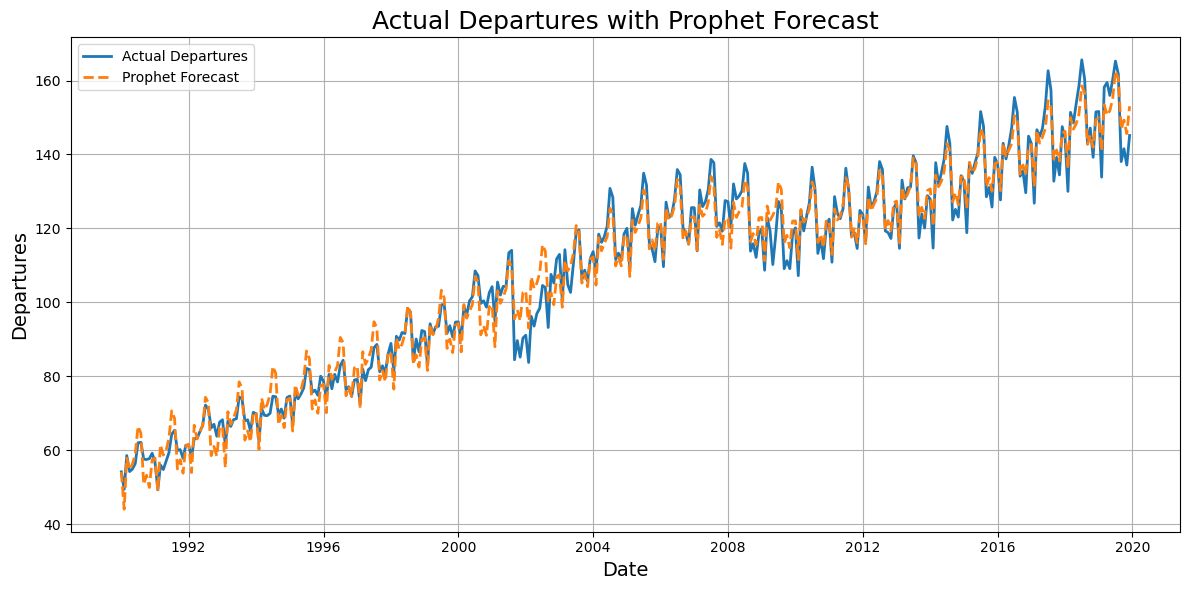

In [30]:
monthly_departures.index = pd.to_datetime(monthly_departures.index)

forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
# Trim forecast to actual data range
forecast_trimmed = forecast_df[forecast_df['ds'] <= '2019-12-01']

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(monthly_departures.index, monthly_departures.values, label='Actual Departures', linewidth=2)

# Plot forecast
plt.plot(forecast_trimmed['ds'], forecast_trimmed['yhat'], label='Prophet Forecast', linewidth=2, linestyle='--')

plt.title("Actual Departures with Prophet Forecast", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Departures", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Frocast with prophet:

In [33]:
# Get the last date in your actual data
last_date = monthly_departures.index.max()

# Forecast 5 years ahead (60 months)
future = model_p.make_future_dataframe(periods=60, freq='ME')
forecast = model_p.predict(future)

# Take only the future part of the forecast
forecast_future = forecast[forecast['ds'] > last_date]

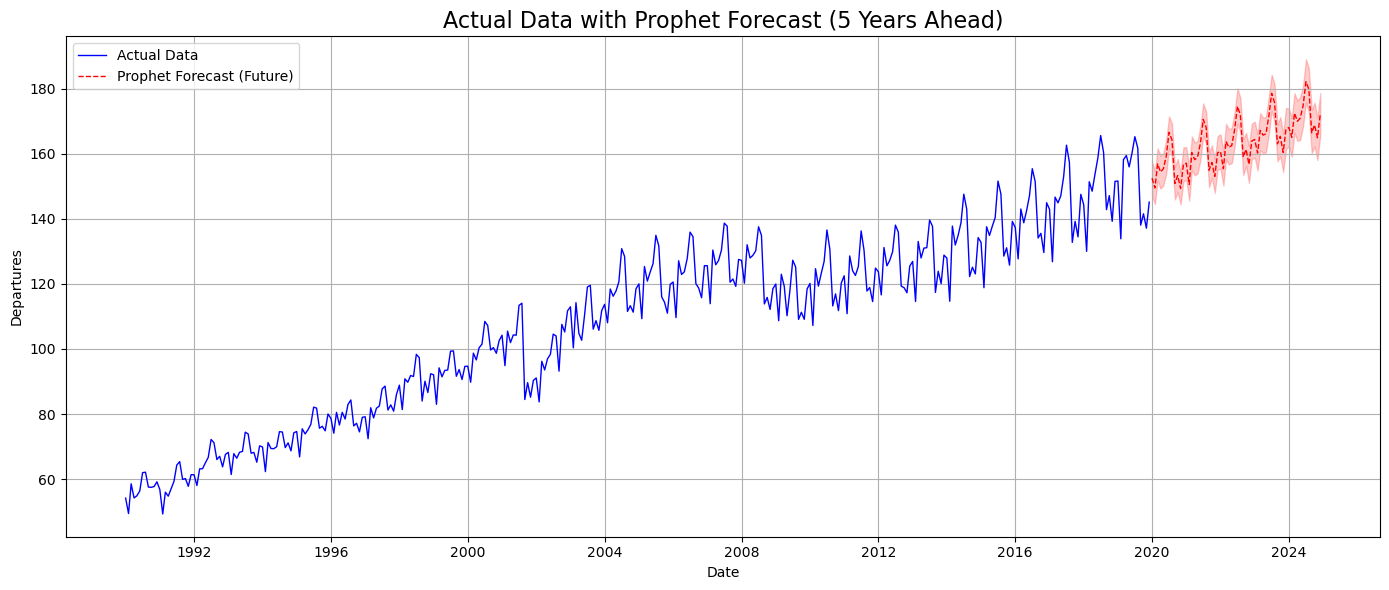

In [34]:
# Actual data
plt.figure(figsize=(14, 6))  

plt.plot(monthly_departures.index, monthly_departures.values, 
         label='Actual Data', color='blue', linewidth=1)

# Forecast line (only future)
plt.plot(forecast_future['ds'], forecast_future['yhat'], 
         label='Prophet Forecast (Future)', color='red', linewidth=1, linestyle='--')

# Confidence interval
plt.fill_between(forecast_future['ds'], 
                 forecast_future['yhat_lower'], 
                 forecast_future['yhat_upper'], 
                 color='red', alpha=0.2)

# Labels & styling
plt.title("Actual Data with Prophet Forecast (5 Years Ahead)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Departures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Exponential Smoothing with Holt winters:

In [36]:
monthly_departures.index = pd.to_datetime(monthly_departures.index)
monthly_departures = monthly_departures.asfreq('MS')  # Monthly Start

# Fit Exponential Smoothing model with trend and seasonality
model = ExponentialSmoothing(
    monthly_departures,
    trend='add',         
    seasonal='add',
    seasonal_periods=12 )

fit = model.fit()

forecast_steps = 60
forecast_index = pd.date_range(start=monthly_departures.index[-1] + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq='MS')

forecast = fit.forecast(forecast_steps)
forecast.index = forecast_index

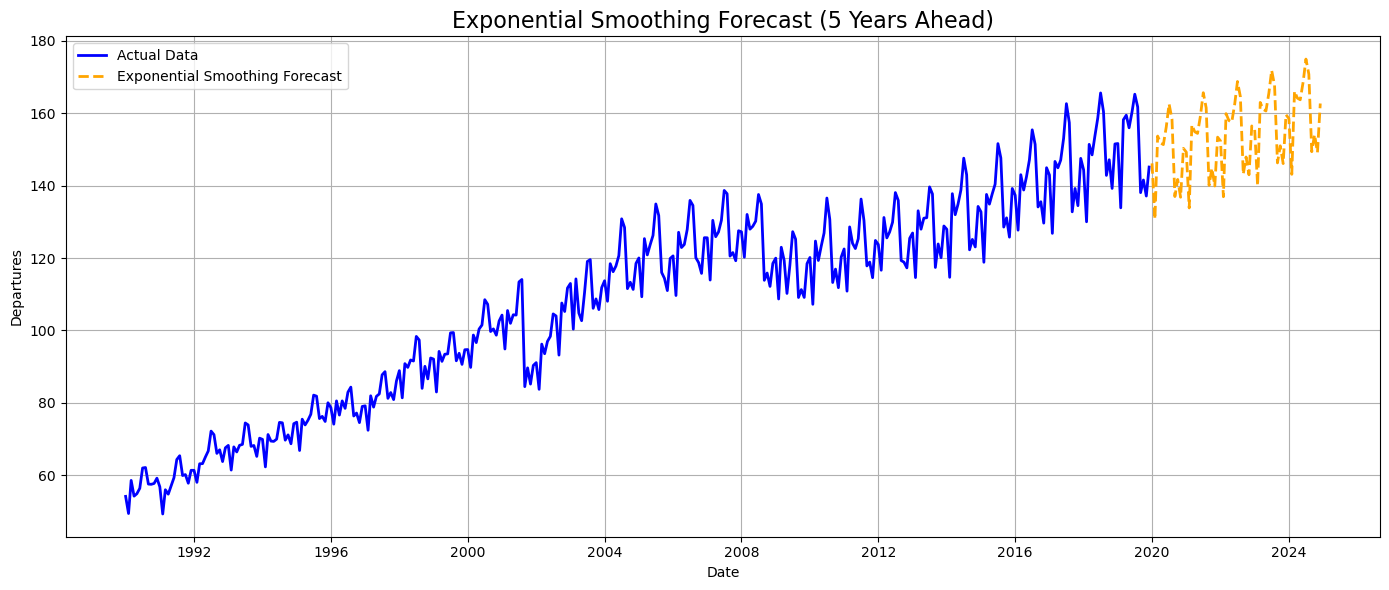

In [37]:
plt.figure(figsize=(14, 6))

# Original data
plt.plot(monthly_departures, label='Actual Data', linewidth=2, color='blue')

# Forecast
plt.plot(forecast, label='Exponential Smoothing Forecast', linewidth=2, color='orange', linestyle='--')

plt.title('Exponential Smoothing Forecast (5 Years Ahead)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Departures')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Forcast with fourier

In [39]:
monthly_departures = monthly_departures.to_frame(name='departures')

monthly_departures.index = pd.to_datetime(monthly_departures.index)
monthly_departures


,departures
year_month,
1990-01-01,54.129
1990-02-01,49.391
1990-03-01,58.542
1990-04-01,54.195
1990-05-01,54.863
...,...
2019-08-01,161.743
2019-09-01,138.071
2019-10-01,141.560


In [40]:
rng = pd.date_range(start = '1990-01-01', end = '2019-12-01', freq='MS')
monthly_departures.set_index(rng, inplace=True)#change index to dates.
monthly_departures.head()


,departures
1990-01-01,54.129
1990-02-01,49.391
1990-03-01,58.542
1990-04-01,54.195
1990-05-01,54.863


In [41]:
slope = (
    monthly_departures['departures'].iloc[-1] - 
    monthly_departures['departures'].iloc[0]
) / (len(monthly_departures) - 1)
slope

0.2535125348189415

In [42]:
trend_values = np.zeros(len(monthly_departures))
for i in range(len(monthly_departures)):
    trend_values[i] = slope * i

In [43]:
monthly_departures['value'] = monthly_departures['departures'] - trend_values


<Axes: >

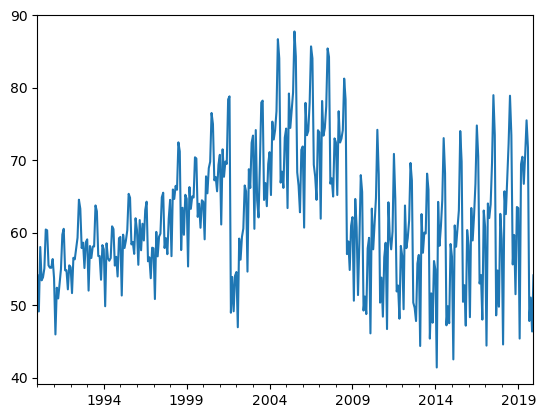

In [44]:
monthly_departures['value'].plot()

as a first step, we attempted to remove a global linear trend from the time series in order to isolate its seasonal component. However, as seen in the detrended series, this approach fails to fully capture the underlying structure of the data. The resulting series still exhibits visible shifts in trend and variability, suggesting that a single linear trend is insufficient. These structural changes, likely due to real-world events or regime shifts, indicate the presence of multiple trend segments over time. To better handle these breaks and to more accurately model the recurring seasonal behavior, we turn to a regression framework that combines Fourier terms with piecewise linear trends. This allows us to flexibly account for both seasonal dynamics and non-uniform trend changes in the data.

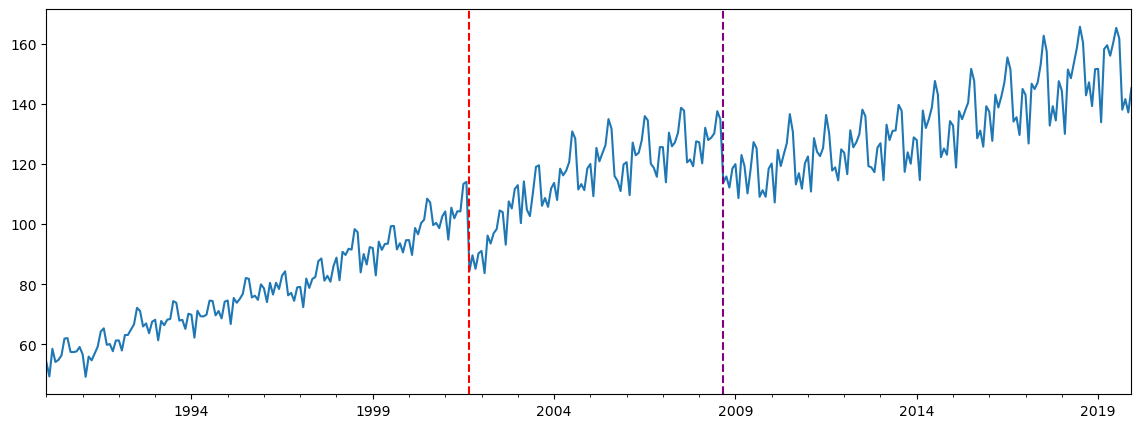

In [46]:
monthly_departures['departures'].plot(figsize=(14, 5))
plt.axvline('2001-09-01', color='red', linestyle='--') 
plt.axvline('2008-09-01', color='purple', linestyle='--')
#plt.axvline('2019-12-01', color='green', linestyle='--')
plt.show()


In [47]:
monthly_departures.index = pd.to_datetime(monthly_departures.index)

monthly_departures = monthly_departures.sort_index()

monthly_departures['t'] = np.arange(len(monthly_departures))

X_linear = np.array([np.ones(len(monthly_departures)), monthly_departures['t']]).T
X_linear[:5] 


array([[1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.]])

In [48]:
# Define the train-test split ratio
split_ratio = 0.8 # 80% for training, 20% for testing
# Calculate the split index
split_index = int(len(monthly_departures) * split_ratio)
# Split the data
train_df = monthly_departures.iloc[:split_index]
train_y = train_df['departures']
test_df = monthly_departures.iloc[split_index:]
test_y = test_df['departures']

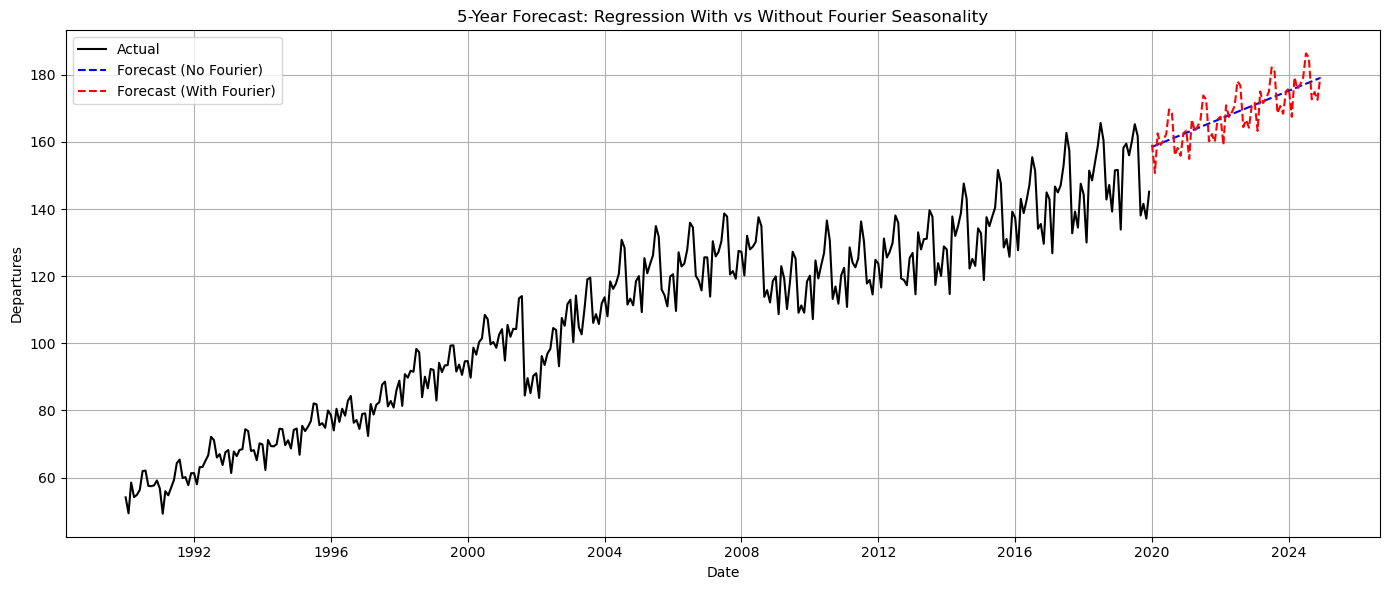

In [49]:
t = np.arange(len(monthly_departures))
monthly_departures['t'] = t

# יצירת X_linear = bias + t
X_linear = np.column_stack([np.ones(len(t)), t])

# שוקים: 2001 ו-2008
shock_2001_slope = np.array([min(int(i >= 141) * (i - 141), 2) for i in t])
shock_2008_slope = np.array([min(int(i >= 225) * (i - 225), 2) for i in t])
X_shocks = np.column_stack([shock_2001_slope, shock_2008_slope])

# טורי פורייה: K=6
lambdas = 2 * np.pi * np.arange(1, 7) / 12
X_seasonality = np.array([
    np.concatenate([np.cos(lambdas * ti), np.sin(lambdas * ti)])
    for ti in t
])

# הגדרת X
X_basic = np.concatenate([X_linear, X_shocks], axis=1)
X_extra = np.concatenate([X_linear, X_seasonality, X_shocks], axis=1)

# y
y = monthly_departures['departures']

# חלוקה ל-train/test
split_index = int(len(monthly_departures) * 0.8)
Xb_train, Xb_test = X_basic[:split_index], X_basic[split_index:]
Xe_train, Xe_test = X_extra[:split_index], X_extra[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# אימון מודלים
model_basic = LinearRegression().fit(Xb_train, y_train)
model_fourier = LinearRegression().fit(Xe_train, y_train)

# תחזית עתידית – 5 שנים
future_steps = 60
t_last = t[-1]
t_future = np.arange(t_last + 1, t_last + future_steps + 1)

# יצירת future features
X_linear_future = np.column_stack([np.ones(len(t_future)), t_future])
shock_2001_future = np.array([min(int(i >= 141) * (i - 141), 2) for i in t_future])
shock_2008_future = np.array([min(int(i >= 225) * (i - 225), 2) for i in t_future])
X_shocks_future = np.column_stack([shock_2001_future, shock_2008_future])
X_fourier_future = np.array([
    np.concatenate([np.cos(lambdas * ti), np.sin(lambdas * ti)])
    for ti in t_future
])
X_basic_future = np.concatenate([X_linear_future, X_shocks_future], axis=1)
X_extra_future = np.concatenate([X_linear_future, X_fourier_future, X_shocks_future], axis=1)

# חיזוי
forecast_basic = model_basic.predict(X_basic_future)
forecast_fourier = model_fourier.predict(X_extra_future)

# תאריכי עתיד
start_date = monthly_departures.index[-1] + pd.offsets.MonthBegin(1)
future_dates = pd.date_range(start=start_date, periods=future_steps, freq='MS')

# ציור
plt.figure(figsize=(14, 6))
plt.plot(monthly_departures.index, monthly_departures['departures'], label="Actual", color='black')
plt.plot(future_dates, forecast_basic, label="Forecast (No Fourier)", linestyle='--', color='blue')
plt.plot(future_dates, forecast_fourier, label="Forecast (With Fourier)", linestyle='--', color='red')
plt.title("5-Year Forecast: Regression With vs Without Fourier Seasonality")
plt.xlabel("Date")
plt.ylabel("Departures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Comparison between the performance of the models: train-test split

 metrics: Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE).
MSE penalizes larger errors more heavily due to the squaring of residuals, making it particularly useful for identifying models that tend to make large mistakes. It also maintains the same scale as the original data, which is helpful when dealing with high-volume variables such as monthly flight departures.
On the other hand, MAPE expresses errors as a percentage of the actual values, providing an intuitive interpretation of model accuracy in relative terms. Since our dataset contains large values and no near-zero entries, MAPE is safe to use and gives a meaningful sense of how far off predictions are in percentage terms.
Using both MSE and MAPE allows us to assess model performance from both absolute and relative perspectives, which leads to more robust and insightful conclusions.



In [52]:
# Define the train-test split ratio
split_ratio = 0.8 # 80% for training, 20% for testing
# Calculate the split index
split_index = int(len(monthly_departures) * split_ratio)
# Split the data
train_df = monthly_departures.iloc[:split_index]
train_y = train_df['departures']
test_df = monthly_departures.iloc[split_index:]
test_y = test_df['departures']
print(test_y)

2014-01-01    127.946
2014-02-01    114.671
2014-03-01    137.781
2014-04-01    131.974
2014-05-01    134.887
               ...   
2019-08-01    161.743
2019-09-01    138.071
2019-10-01    141.560
2019-11-01    137.130
2019-12-01    145.140
Freq: MS, Name: departures, Length: 72, dtype: float64


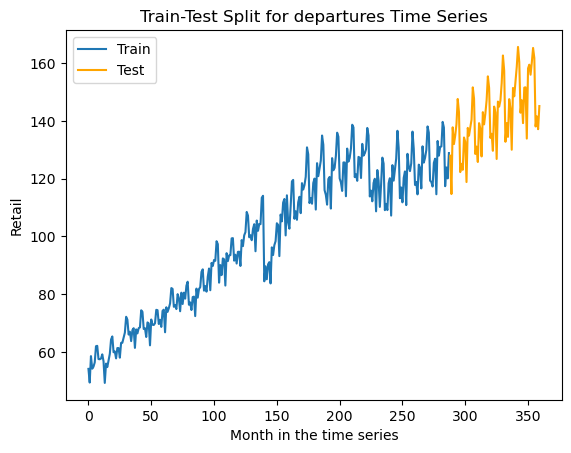

Train Data Shape: (288, 3)
Test Data Shape: (72, 3)


In [53]:
 # Plot the train-test split
plt.plot(np.arange(len(train_df)), train_df['departures'], label='Train')
plt.plot(np.arange(len(train_df), len(monthly_departures)), test_df['departures'], label='Test', color='orange')
plt.xlabel('Month in the time series')
plt.ylabel('Retail')
plt.title('Train-Test Split for departures Time Series')
plt.legend()
plt.show()
# Print shapes of splits
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

In [54]:
# פונקציות אימון וחיזוי לכל מודל
def train_predict_sarima(train_y, test_y):
    model = SARIMAX(train_y, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
    fitted = model.fit(disp=False)
    forecast = fitted.forecast(steps=len(test_y))
    mse = mean_squared_error(test_y, forecast)
    mape = mean_absolute_percentage_error(test_y, forecast)
    return forecast, mse, mape

def train_predict_expsmooth(train_y, test_y):
    model = ExponentialSmoothing(train_y, trend='add', seasonal='add', seasonal_periods=12)
    fitted = model.fit()
    forecast = fitted.forecast(steps=len(test_y))
    mse = mean_squared_error(test_y, forecast)
    mape = mean_absolute_percentage_error(test_y, forecast)
    return forecast, mse, mape

def train_predict_prophet(prophet_df, test_len, test_y):
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
    model.fit(prophet_df)
    future = model.make_future_dataframe(periods=test_len, freq='MS')
    forecast = model.predict(future)
    y_hat = forecast['yhat'].iloc[-test_len:].values
    mse = mean_squared_error(test_y, y_hat)
    mape = mean_absolute_percentage_error(test_y, y_hat)
    return y_hat, mse, mape

# רשימת המודלים
models_names_list = ["Sarima", "ExponentialSmoothing", "Prophet"]
models = {}
MSE = {}
MAPE = {}
y_preds = {}
prophet_trained_model = None  # נשמור כאן את מודל פרופט

# יצירת df לפרופט
prophet_df = monthly_departures.reset_index().rename(columns={
    'year_month': 'ds', 'departures': 'y'
})
prophet_df = prophet_df[['index', 'y']].rename(columns={'index': 'ds'})

# הרצת כל המודלים
for model_name in models_names_list:
    print(f"\n Training {model_name}...")

    if model_name == "Sarima":
        y_hat, mse, mape = train_predict_sarima(train_y, test_y)

    elif model_name == "ExponentialSmoothing":
        y_hat, mse, mape = train_predict_expsmooth(train_y, test_y)

    elif model_name == "Prophet":
        # אימון ושמירה
        model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
        model.fit(prophet_df)
        prophet_trained_model = model  # שמור את המודל

        future = model.make_future_dataframe(periods=len(test_y), freq='MS')
        forecast = model.predict(future)
        y_hat = forecast['yhat'].iloc[-len(test_y):].values
        mse = mean_squared_error(test_y, y_hat)
        mape = mean_absolute_percentage_error(test_y, y_hat)

    models[model_name] = y_hat
    y_preds[model_name] = y_hat
    MSE[model_name] = mse
    MAPE[model_name] = mape
    print(f" {model_name} done. MSE = {mse:.2f}, MAPE = {mape:.2f}%")

# תצוגת טבלה
results_df = pd.DataFrame({
    'MSE': MSE,
    'MAPE (%)': MAPE
}).sort_values(by='MSE')

print("\n Model Performance:")
print(results_df)




 Training Sarima...
 Sarima done. MSE = 189.18, MAPE = 0.08%

 Training ExponentialSmoothing...
 ExponentialSmoothing done. MSE = 19.69, MAPE = 0.02%

 Training Prophet...


20:52:37 - cmdstanpy - INFO - Chain [1] start processing
20:52:37 - cmdstanpy - INFO - Chain [1] done processing


 Prophet done. MSE = 558.25, MAPE = 0.17%

 Model Performance:
                             MSE  MAPE (%)
ExponentialSmoothing   19.694172  0.023964
Sarima                189.175099  0.080529
Prophet               558.247323  0.166556


In [55]:
def plot_forecasts(test_y, y_preds, models_names_list, start_index=None):
    """
    Plots the actual values vs. predicted values from multiple models.

    Parameters:
    - test_y: Series or array of actual test values
    - y_preds: dict of model_name -> predicted values (arrays)
    - models_names_list: list of model names (for consistent ordering)
    - start_index: optional - index offset to align x-axis if needed
    """
    plt.figure(figsize=(14, 6))
    
    x = test_y.index

    # הערכים האמיתיים
    plt.plot(x, test_y, label='Actual', linewidth=2, color='black')

    # חיזוי של כל מודל
    for model_name in models_names_list:
        plt.plot(x, y_preds[model_name], label=f"{model_name} Forecast", linestyle='--')

    # עיצוב גרפי
    plt.title("Forecast vs Actual - All Models")
    plt.xlabel("Time")
    plt.ylabel("Departures")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


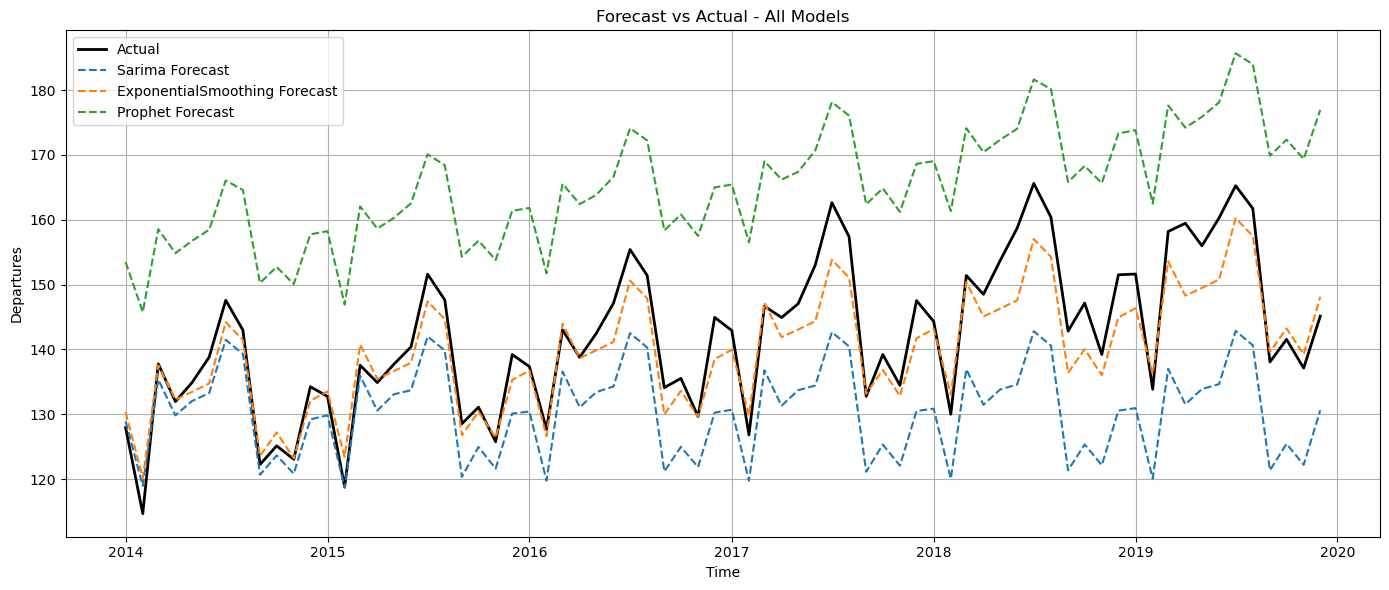

In [56]:
plot_forecasts(test_y, y_preds, models_names_list)

In [57]:
# תחזית על סט האימון בלבד
train_len = len(train_y)
future_train = prophet_trained_model.make_future_dataframe(periods=0, freq='MS')
forecast_train = prophet_trained_model.predict(future_train)

y_train_pred = forecast_train['yhat'].iloc[:train_len].values
mse_train = mean_squared_error(train_y, y_train_pred)
mape_train = mean_absolute_percentage_error(train_y, y_train_pred) * 100

print("\n Prophet Performance on Training Set:")
print(f"MSE: {mse_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")


 Prophet Performance on Training Set:
MSE: 15.66
MAPE: 3.37%


Despite the excellent performance of Prophet on the training set, its significantly higher error on the test set compared to other models may indicate overfitting. While we did not conduct a full hyperparameter optimization, it is likely that tuning Prophet’s regularization parameter (such as changepoint_prior_scale) could improve generalization. Nevertheless, most of the models we tested—particularly Exponential Smoothing and Regression with Fourier terms—demonstrated strong and consistent performance on the test set, achieving very low MSE and MAPE values. The regression-based models will be explored further in the following sections of the work.



### linear trend + seasonality


In [60]:
def plot_preds(y_preds, y_true, title):
    """
    Plot the results of each model fitting.

    Parameters:
    y_preds (dict): keys=model_names, values=predicted values
    y_true (array-like): actual values
    title (str): title for the plot
    """
    plt.figure(figsize=(10, 6))
    
    for model_name, y_pred in y_preds.items():
        if model_name == "Linear (with Fourier)":
            plt.plot(y_true.index, y_pred, label=model_name, color='red', linewidth=2.5)
        else:
            plt.plot(y_true.index, y_pred, label=model_name, alpha=0.4, linestyle='--')
    
    # True values
    plt.plot(y_true, label='True', color='black', linewidth=2)

    # Labels and title
    plt.xlabel('Month in the time series')
    plt.ylabel('Departures')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Linear (no Fourier) MSE: 101.74, MAPE: 0.06%
Linear (with Fourier) MSE: 38.05, MAPE: 0.04%


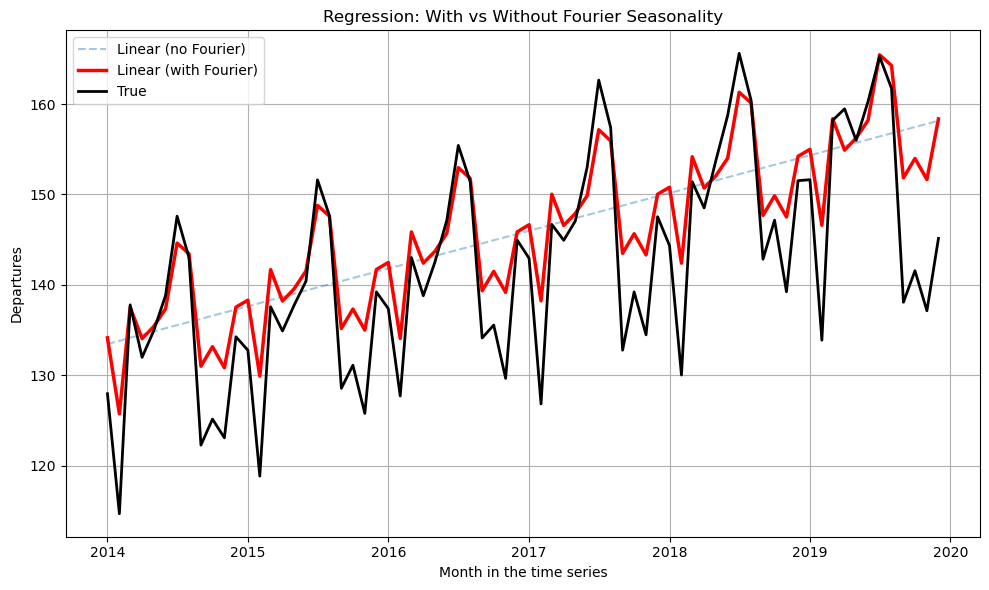


 Regression Models Performance:
                              MSE  MAPE (%)
Linear (with Fourier)   38.052373  0.035230
Linear (no Fourier)    101.741288  0.058192


In [61]:
# אימון מודלים + MSE + MAPE
models = {
    "Linear (no Fourier)": LinearRegression(),
    "Linear (with Fourier)": LinearRegression()
}

y_preds = {}
MSE = {}
MAPE = {}

for name, model in models.items():
    if "no Fourier" in name:
        model.fit(Xb_train, y_train)
        preds = model.predict(Xb_test)
    else:
        model.fit(Xe_train, y_train)
        preds = model.predict(Xe_test)

    y_preds[name] = preds
    MSE[name] = mean_squared_error(y_test, preds)
    MAPE[name] = mean_absolute_percentage_error(y_test, preds)
    print(f"{name} MSE: {MSE[name]:.2f}, MAPE: {MAPE[name]:.2f}%")

# ציור
y_test = pd.Series(y_test.values, index=monthly_departures.index[split_index:])
plot_preds(y_preds, y_test, "Regression: With vs Without Fourier Seasonality")

# טבלת תוצאות
results_df = pd.DataFrame({
    'MSE': MSE,
    'MAPE (%)': MAPE
}).sort_values(by='MSE')

print("\n Regression Models Performance:")
print(results_df)

MSE: 21.76
MAPE: 0.03%


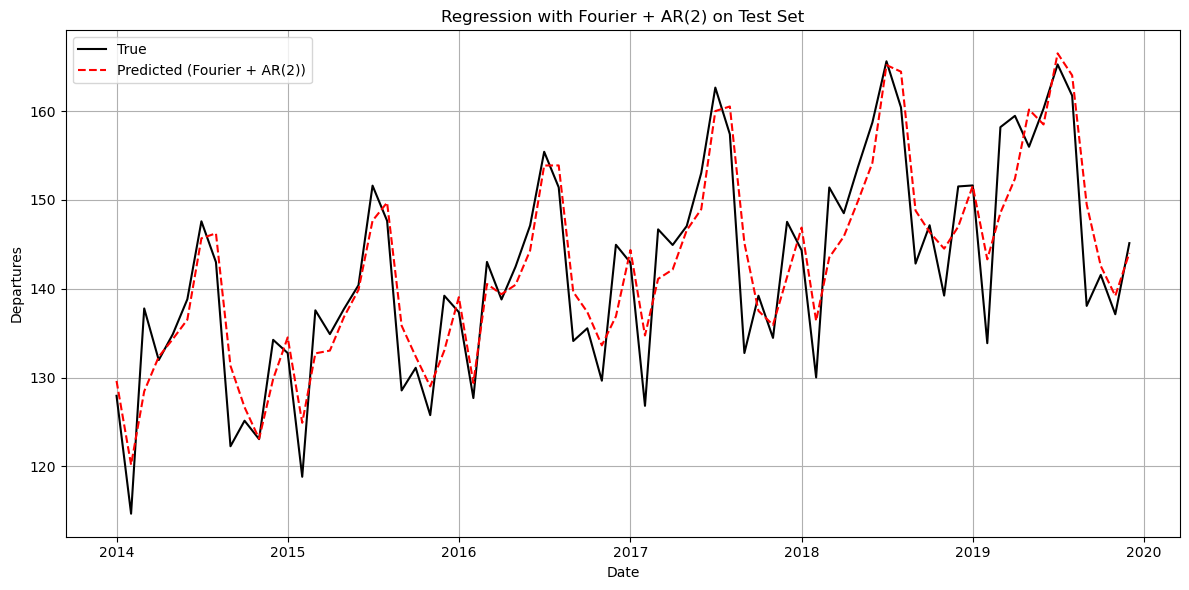

In [62]:
y = monthly_departures['departures'].values
t = monthly_departures['t'].values
X_seasonality = X_seasonality  # ממה שהוגדר מראש

# יצירת משתני עזר y(t-1) ו־y(t-2)
y_lag1 = np.roll(y, 1)
y_lag2 = np.roll(y, 2)
y_lag1[:2] = np.nan
y_lag2[:2] = np.nan

# משתני מגמה: bias ו־t
X_linear = np.column_stack([np.ones(len(t)), t])

# חיבור הכל: מגמה + פורייה + השהיות
X_ar2 = np.column_stack([X_linear, X_seasonality, y_lag1, y_lag2])
y_target = y.copy()

# סינון NaNs
valid_idx = ~np.isnan(X_ar2).any(axis=1)
X_ar2 = X_ar2[valid_idx]
y_target = y_target[valid_idx]
dates = monthly_departures.index[valid_idx]

# חלוקה ל־train/test
split_index = int(len(y_target) * 0.8)
X_train, X_test = X_ar2[:split_index], X_ar2[split_index:]
y_train, y_test = y_target[:split_index], y_target[split_index:]
test_dates = dates[split_index:]

# אימון המודל
model_ar2 = LinearRegression()
model_ar2.fit(X_train, y_train)

# חיזוי
y_pred_ar2 = model_ar2.predict(X_test)

# מדדים
mse = mean_squared_error(y_test, y_pred_ar2)
mape = mean_absolute_percentage_error(y_test, y_pred_ar2) 
print(f"MSE: {mse:.2f}")
print(f"MAPE: {mape:.2f}%")

# ציור
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='True', color='black')
plt.plot(test_dates, y_pred_ar2, label='Predicted (Fourier + AR(2))', linestyle='--', color='red')
plt.title("Regression with Fourier + AR(2) on Test Set")
plt.xlabel("Date")
plt.ylabel("Departures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Part 3 - exogenous data

We selected the CPI indicators for Energy, Transportation, and Gasoline because they are directly related to factors that influence flight activity. Energy and gasoline costs affect airline operational expenses, fuel prices, and ticket pricing. Transportation CPI reflects broader travel costs, including public and private transport demand. By combining these variables, we aim to capture both the cost-side and demand-side drivers that can help explain changes in the volume of flight departures.

In [65]:
df = pd.read_csv("cpi.csv")
print(df.isna().sum())        # count NaNs
print(df.index.is_unique)     # does the dates are unique?
df

series_id              0
year                   0
period                 0
value                  0
footnote_codes    276773
dtype: int64
True


,series_id,year,period,value,footnote_codes
0,CUSR0000SA0,1947,M01,21.480,NaN
1,CUSR0000SA0,1947,M02,21.620,NaN
2,CUSR0000SA0,1947,M03,22.000,NaN
3,CUSR0000SA0,1947,M04,22.000,NaN
4,CUSR0000SA0,1947,M05,21.950,NaN
...,...,...,...,...,...
276768,CUUSS49GSAT,2023,S02,295.639,NaN
276769,CUUSS49GSAT,2023,S03,288.728,NaN
276770,CUUSS49GSAT,2024,S01,283.271,NaN
276771,CUUSS49GSAT,2024,S02,282.552,NaN


In [66]:
# שלבים ראשונים לעיבוד חודש + תאריך
df = df[df['period'].str.startswith('M')]
df['month'] = df['period'].str.extract(r'M(\d{2})').astype(int)
df = df[(df['month'] >= 1) & (df['month'] <= 12)]
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2) + '-01')

# סינון טווח תאריכים
start_date = pd.Timestamp("1990-01-01")
end_date = pd.Timestamp("2019-12-01")
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# חלוקה לסדרות
energy_df = df[df['series_id'] == 'CUSR0000SAE'] #this is the sereis id of the energy cpi
transportation_df = df[df['series_id'] == 'CUSR0000SAT']#this is the sereis id of the transportation cpi
gasoline_df = df[df['series_id'] == 'CUSR0000SAG']#this is the sereis id of the gasoline cpi

C:\Users\eladn\AppData\Local\Temp\ipykernel_6892\609966597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['period'].str.extract(r'M(\d{2})').astype(int)


Since some CPI(energy cpi) series did not contain entries for every month in the target date range (1990–2019), we first reindexed each series to include all monthly timestamps. This ensured a consistent temporal structure across all datasets. After reindexing, we filled any missing values using the mean of each individual series, preserving trends while avoiding loss of temporal coverage during merging.



In [68]:
full_range = pd.date_range(start='1990-01-01', end='2019-12-01', freq='MS')
# הגדלה של כל סדרה לטווח מלא
energy_df = energy_df.set_index('date').reindex(full_range).rename_axis('date').reset_index()
transportation_df = transportation_df.set_index('date').reindex(full_range).rename_axis('date').reset_index()
gasoline_df = gasoline_df.set_index('date').reindex(full_range).rename_axis('date').reset_index()

#energy cpi
print(energy_df.isna().sum())        # count NaNs
print(energy_df.index.is_unique)     # does the dates are unique?
#transportation cpi
print(transportation_df.isna().sum())        # count NaNs
print(transportation_df.index.is_unique)     # does the dates are unique?
#gasoline cpi
print(gasoline_df.isna().sum())        # count NaNs
print(gasoline_df.index.is_unique)     # does the dates are unique?


date                0
series_id          36
year               36
period             36
value              36
footnote_codes    360
month              36
dtype: int64
True
date                0
series_id           0
year                0
period              0
value               0
footnote_codes    360
month               0
dtype: int64
True
date                0
series_id           0
year                0
period              0
value               0
footnote_codes    360
month               0
dtype: int64
True


Since the CPI Energy series contains no data at all between 1990 and 1992, we considered three options for handling the missing values: (1) filling with zeros, (2) discarding the entire energy series, or (3) imputing the missing values based on the first available observation in January 1993. Filling with zeros was ruled out because CPI is a relative index, and inserting zeros would drastically distort the scale and reduce the overall level of the series. Discarding the series altogether would result in the loss of a potentially meaningful explanatory variable. Therefore, we chose to fill the missing entries from 1990 to 1992 using the value from January 1993, assuming that the early values were relatively stable and comparable to the earliest available data point. This approach preserves continuity in the dataset while minimizing distortion.

In [70]:
#filling missing values in energy_df
#energy_df['value'] = energy_df['value'].fillna(0)

# שלב 1: ערך ייחוס – ינואר 1993
ref_value = energy_df.loc[energy_df['date'] == '1993-01-01', 'value'].values[0]

# שלב 2: יצירת תאריכי חוסר
missing_dates = pd.date_range(start='1990-01-01', end='1992-12-01', freq='MS')
missing_df = pd.DataFrame({
    'date': missing_dates,
    'value': ref_value,
    'series_id': 'CUSR0000SAE',
    'year': missing_dates.year,
    'period': ['M' + str(m).zfill(2) for m in missing_dates.month],
})

# שלב 3: מחיקה מהמקור אם בטעות יש תאריכים חופפים
energy_df_clean = energy_df[~energy_df['date'].isin(missing_dates)]

# שלב 4: איחוד וחידוש האינדקס
energy_df= pd.concat([missing_df, energy_df_clean], ignore_index=True).sort_values(by='date').reset_index(drop=True)




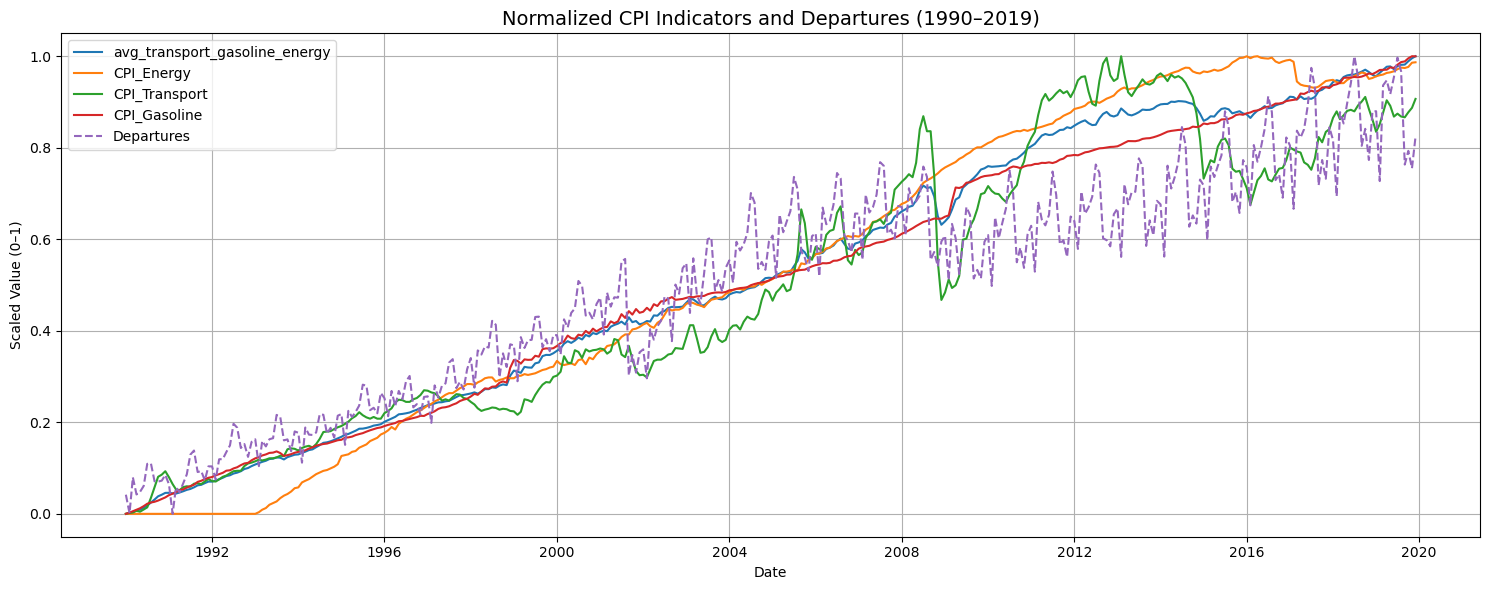

In [71]:
# --- 2. מיזוג סדרות ויצירת ממוצע חדש כולל אנרגיה ---
merged_all = pd.merge(
    transportation_df[['date', 'value']],
    gasoline_df[['date', 'value']],
    on='date',
    suffixes=('_transport', '_gasoline')
)

merged_all = pd.merge(
    merged_all,
    energy_df[['date', 'value']],
    on='date'
).rename(columns={'value': 'value_energy'})

merged_all['avg_transport_gasoline_energy'] = merged_all[
    ['value_transport', 'value_gasoline', 'value_energy']
].mean(axis=1)

# --- 3. עיבוד נתוני הטיסות ---
monthly_departures.index = pd.to_datetime(monthly_departures.index)
departures_df = monthly_departures.reset_index().rename(columns={'index': 'date'})

# --- 4. בניית DataFrame משולב ---
combined_df = merged_all[['date', 'avg_transport_gasoline_energy']].copy()

combined_df = combined_df.merge(energy_df[['date', 'value']], on='date', how='left')
combined_df = combined_df.rename(columns={'value': 'CPI_Energy'})

combined_df = combined_df.merge(transportation_df[['date', 'value']], on='date', how='left')
combined_df = combined_df.rename(columns={'value': 'CPI_Transport'})

combined_df = combined_df.merge(gasoline_df[['date', 'value']], on='date', how='left')
combined_df = combined_df.rename(columns={'value': 'CPI_Gasoline'})

# ודא שיש לך עמודת departures בטבלה הזו
combined_df = combined_df.merge(departures_df[['date', 'departures']], on='date', how='inner')
combined_df = combined_df.rename(columns={'departures': 'Departures'})

# --- 5. נרמול ---
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(combined_df.drop(columns='date'))
scaled_df = pd.DataFrame(scaled_values, columns=combined_df.columns[1:], index=combined_df['date'])

# --- 6. ציור ---
plt.figure(figsize=(15, 6))

for col in scaled_df.columns:
    linestyle = '--' if col == 'Departures' else '-'
    plt.plot(scaled_df.index, scaled_df[col], label=col, linestyle=linestyle)

plt.title("Normalized CPI Indicators and Departures (1990–2019)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Scaled Value (0–1)")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [72]:
# הוספת עמודת ממוצע
combined_df['avg_transport_gasoline_energy'] = combined_df[
    ['CPI_Energy', 'CPI_Transport', 'CPI_Gasoline']
].mean(axis=1)

exog_variables = ['CPI_Energy', 'CPI_Transport', 'CPI_Gasoline', 'avg_transport_gasoline_energy']

results = []

for exog_var in exog_variables:
    print(f"Running SARIMA with exogenous variable: {exog_var}")

    df = combined_df[['Departures', exog_var]].dropna()

    # חלוקה ל-train/test
    split_ratio = 0.8
    split_index = int(len(df) * split_ratio)
    train_y = df['Departures'].iloc[:split_index]
    test_y = df['Departures'].iloc[split_index:]
    train_exog = df[[exog_var]].iloc[:split_index]
    test_exog = df[[exog_var]].iloc[split_index:]

    # SARIMA עם משתנה אקסוגני
    model = SARIMAX(train_y, exog=train_exog, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
    fitted_model = model.fit(disp=False)

    forecast = fitted_model.forecast(steps=len(test_y), exog=test_exog)

    # חישוב מדדים
    mse = mean_squared_error(test_y, forecast)
    mape = mean_absolute_percentage_error(test_y, forecast)

    results.append((exog_var, mse, mape))

# טבלת תוצאות
results_df = pd.DataFrame(results, columns=['Exogenous Variable', 'MSE', 'MAPE (%)'])
results_df = results_df.sort_values(by='MSE')

print("\n MSE & MAPE by Exogenous Variable:")
print(results_df)

Running SARIMA with exogenous variable: CPI_Energy
Running SARIMA with exogenous variable: CPI_Transport
Running SARIMA with exogenous variable: CPI_Gasoline
Running SARIMA with exogenous variable: avg_transport_gasoline_energy

 MSE & MAPE by Exogenous Variable:
              Exogenous Variable         MSE  MAPE (%)
0                     CPI_Energy  114.593500  0.062431
2                   CPI_Gasoline  182.614331  0.079173
3  avg_transport_gasoline_energy  185.475302  0.081470
1                  CPI_Transport  213.736219  0.087497


In [73]:
print("\n Training SARIMA without exogenous variables...")

# חלוקה ל-train/test
split_ratio = 0.8
split_index = int(len(monthly_departures) * split_ratio)
train_df = monthly_departures.iloc[:split_index]
train_y = train_df['departures']
test_df = monthly_departures.iloc[split_index:]
test_y = test_df['departures']

# מודל SARIMA רגיל (ללא exog)
model = SARIMAX(train_y, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
fitted_model = model.fit(disp=False)
forecast = fitted_model.forecast(steps=len(test_y))

# חישוב מדדים
mse = mean_squared_error(test_y, forecast)
mape = mean_absolute_percentage_error(test_y, forecast)
print(f" SARIMA without exog done. MSE = {mse:.2f}, MAPE = {mape:.2f}%")

# הוספה לטבלה הקיימת
results_df = pd.concat([
    results_df,
    pd.DataFrame([['SARIMA (no exog)', mse, mape]], columns=['Exogenous Variable', 'MSE', 'MAPE (%)'])
], ignore_index=True)

# מיון לפי MSE
results_df = results_df.sort_values(by='MSE')

print("\n Final comparison including SARIMA without exog:")
print(results_df)


 Training SARIMA without exogenous variables...
 SARIMA without exog done. MSE = 189.18, MAPE = 0.08%

 Final comparison including SARIMA without exog:
              Exogenous Variable         MSE  MAPE (%)
0                     CPI_Energy  114.593500  0.062431
1                   CPI_Gasoline  182.614331  0.079173
2  avg_transport_gasoline_energy  185.475302  0.081470
4               SARIMA (no exog)  189.175099  0.080529
3                  CPI_Transport  213.736219  0.087497


In [74]:
def plot_exog_vs_base_sarima(test_y, y_preds_exog, base_sarima_forecast, title="SARIMA Forecasts Comparison"):
    """
    Plots actual vs forecasted values for SARIMA models with exogenous variables
    and a base SARIMA model without exogenous variables.

    Parameters:
    - test_y: Series of actual values (with datetime index)
    - y_preds_exog: dict of exog_name -> forecast array (from SARIMA + exog)
    - base_sarima_forecast: forecast array from SARIMA without exogenous variable
    - title: plot title
    """
    plt.figure(figsize=(15, 6))

    # ציר X לפי אינדקס של סדרת האמת
    x = test_y.index

    # ערכים אמיתיים
    plt.plot(x, test_y, label='Actual', color='black', linewidth=2)

    # SARIMA בלי exog
    plt.plot(x, base_sarima_forecast, label='SARIMA (No exog)', color='gray', linestyle='--')

    # SARIMA עם כל exog
    for exog_name, forecast in y_preds_exog.items():
        plt.plot(x, forecast, label=f"SARIMA + {exog_name}", linestyle='--')

    # עיצוב
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Departures")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


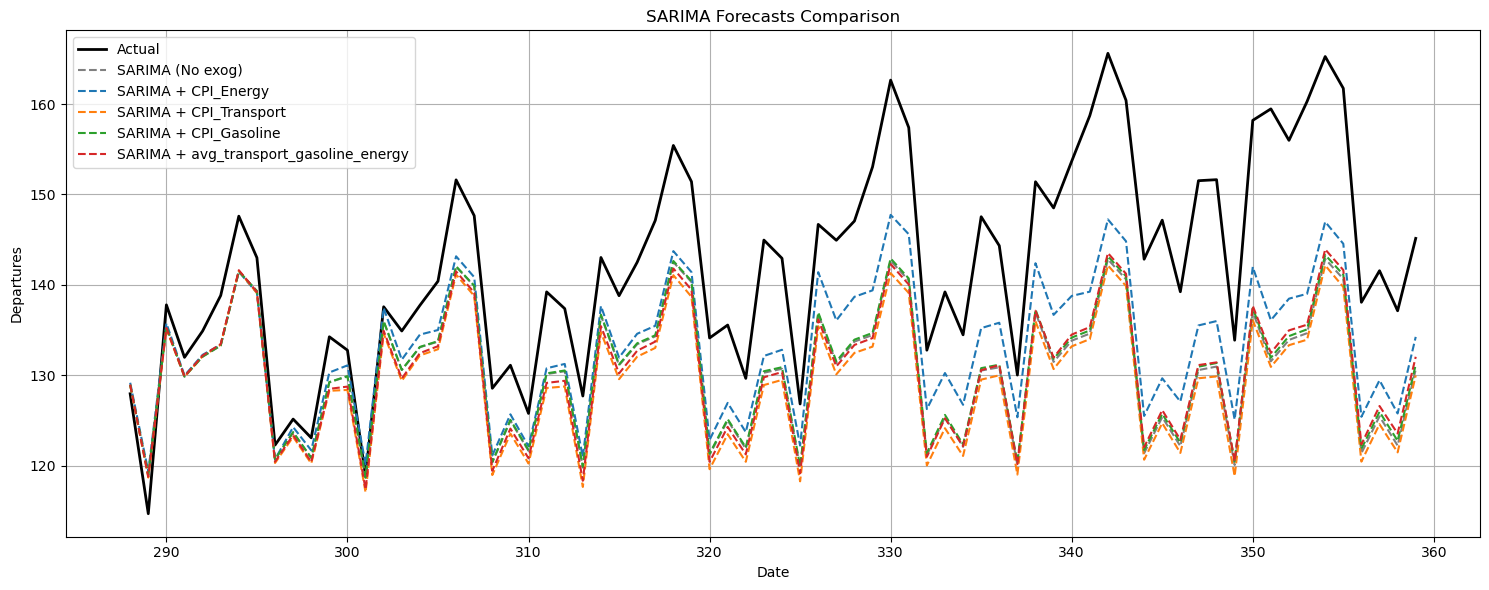

In [75]:
exog_variables = ['CPI_Energy', 'CPI_Transport', 'CPI_Gasoline', 'avg_transport_gasoline_energy']

# הכנה
y_preds_exog = {}
test_y = None
sarima_forecast = None

for exog_var in exog_variables:
    df = combined_df[['Departures', exog_var]].dropna()

    split_index = int(len(combined_df) * 0.8)

    # חלוקה מסודרת - אין צורך לחזור ל-monthly_departures
    train_y = combined_df['Departures'].iloc[:split_index]
    test_y = combined_df['Departures'].iloc[split_index:]
    train_exog = combined_df[[exog_var]].iloc[:split_index]
    test_exog = combined_df[[exog_var]].iloc[split_index:]

    # אימון SARIMA עם exog
    model = SARIMAX(train_y, exog=train_exog, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
    fitted = model.fit(disp=False)
    forecast = fitted.forecast(steps=len(test_y), exog=test_exog)

    # שמירת תחזית
    y_preds_exog[exog_var] = forecast

# SARIMA בלי exog
df_base = combined_df[['Departures']].dropna()
split_index = int(len(df_base) * 0.8)
train_y = df_base['Departures'].iloc[:split_index]
test_y = df_base['Departures'].iloc[split_index:]

model = SARIMAX(train_y, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
fitted = model.fit(disp=False)
sarima_forecast = fitted.forecast(steps=len(test_y))

# ציור:
plot_exog_vs_base_sarima(test_y, y_preds_exog, sarima_forecast)


### exogenous data with fourier and Regression

In [77]:
exog_vars_list = [
    None,
    ['CPI_Energy'],
    ['CPI_Transport'],
    ['CPI_Gasoline'],
    ['avg_transport_gasoline_energy'],
    #['CPI_Energy', 'CPI_Transport', 'CPI_Gasoline'],
    #['CPI_Energy', 'CPI_Transport', 'CPI_Gasoline', 'avg_transport_gasoline_energy']
]

results = []

for exog_vars in exog_vars_list:
    if exog_vars is None:
        print(" Training with NO exogenous variables")
        X_total = np.concatenate([X_linear, X_seasonality, X_shocks], axis=1)
        label = 'No Exogenous Variables'
    else:
        print(f" Training with exogenous variables: {exog_vars}")
        X_exog = combined_df[exog_vars].values
        X_total = np.concatenate([X_linear, X_seasonality, X_shocks, X_exog], axis=1)
        label = ' + '.join(exog_vars)
    
    # חלוקה ל-train/test
    X_train, X_test = X_total[:split_index], X_total[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    # אימון
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # חישוב שגיאות
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    results.append((label, mse, mape))

# טבלה מסכמת
results_df = pd.DataFrame(results, columns=['Exogenous Variables', 'MSE', 'MAPE (%)']).sort_values(by='MSE')
print(results_df)


 Training with NO exogenous variables
 Training with exogenous variables: ['CPI_Energy']
 Training with exogenous variables: ['CPI_Transport']
 Training with exogenous variables: ['CPI_Gasoline']
 Training with exogenous variables: ['avg_transport_gasoline_energy']
             Exogenous Variables        MSE  MAPE (%)
0         No Exogenous Variables  38.052373  0.035230
3                   CPI_Gasoline  39.058590  0.035803
2                  CPI_Transport  54.513754  0.043458
1                     CPI_Energy  88.394064  0.055468
4  avg_transport_gasoline_energy  89.077985  0.057852


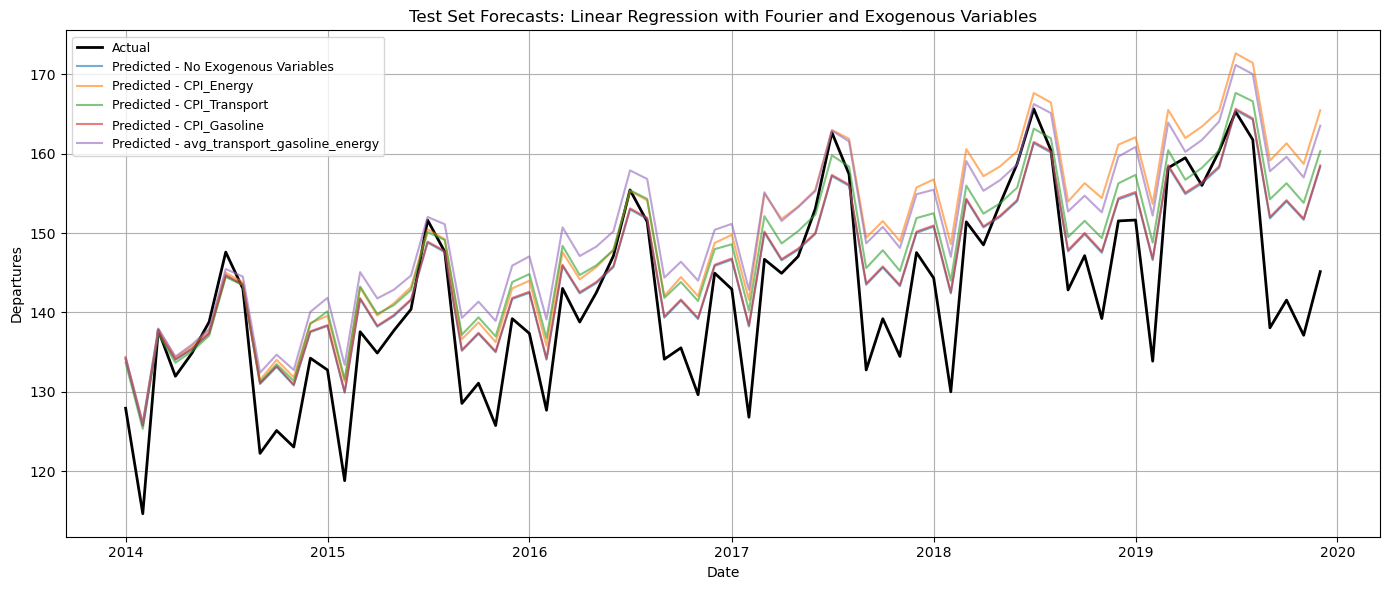

In [78]:
plt.figure(figsize=(14, 6))

# ציר X: תאריכים של סט המבחן
test_index = monthly_departures.index[split_index:]

# ציור הערכים האמיתיים
plt.plot(test_index, y_test, label='Actual', color='black', linewidth=2)

# ציור התחזיות של כל מודל (לפי results)
for i, (label, _, _) in enumerate(results):
    if label == 'No Exogenous Variables':
        X_total = np.concatenate([X_linear, X_seasonality, X_shocks], axis=1)
    else:
        exog_vars = label.split(' + ')
        X_exog = combined_df[exog_vars].values
        X_total = np.concatenate([X_linear, X_seasonality, X_shocks, X_exog], axis=1)

    X_test = X_total[split_index:]
    model = LinearRegression()
    model.fit(X_total[:split_index], y[:split_index])
    y_pred = model.predict(X_test)

    plt.plot(test_index, y_pred, label=f'Predicted - {label}', alpha=0.6)

# עיצוב
plt.title("Test Set Forecasts: Linear Regression with Fourier and Exogenous Variables")
plt.xlabel("Date")
plt.ylabel("Departures")
plt.legend(loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()


### part 4

### The Shewhart Control Chart

To identify the most suitable SARIMA model for further analysis, including potential structural break tests, we evaluated a set of models with and without exogenous variables. Specifically, we considered CPI indicators such as Energy, Transportation, Gasoline, and their combined average as exogenous regressors. Each model was fitted on the full dataset without a train-test split, and the Bayesian Information Criterion (BIC) was used as the selection metric. The model with the lowest BIC was selected as the best-fitting model, indicating the most efficient balance between goodness-of-fit and model complexity.



In [82]:
# יצירת משתנה ממוצע בין הסדרות
combined_df['avg_transport_gasoline_energy'] = combined_df[
    ['CPI_Energy', 'CPI_Transport', 'CPI_Gasoline']
].mean(axis=1)

# משתנים אקסוגניים לבדיקה
exog_variables = ['CPI_Energy', 'CPI_Transport', 'CPI_Gasoline', 'avg_transport_gasoline_energy', None]

results = []
best_bic = float('inf')
best_model = None
best_label = ""

for exog_var in exog_variables:
    label = exog_var if exog_var is not None else 'No Exogenous Variable'
    print(f"Training SARIMA on full data with: {label}")

    if exog_var is not None:
        df = combined_df[['Departures', exog_var]].dropna()
        exog = df[[exog_var]]
    else:
        df = combined_df[['Departures']].dropna()
        exog = None

    y = df['Departures']

    # התאמת מודל על כל הדאטא
    model = SARIMAX(y, exog=exog, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
    fitted_model = model.fit(disp=False)

    bic = fitted_model.bic
    results.append((label, bic))

    if bic < best_bic:
        best_bic = bic
        best_model = fitted_model
        best_label = label

# הצגת תוצאות
results_df = pd.DataFrame(results, columns=['Model', 'BIC']).sort_values(by='BIC')
print("\nSARIMA Model BIC Comparison:")
print(results_df)

print(f"\n Best model by BIC: {best_label} (BIC = {best_bic:.2f})")


Training SARIMA on full data with: CPI_Energy
Training SARIMA on full data with: CPI_Transport
Training SARIMA on full data with: CPI_Gasoline
Training SARIMA on full data with: avg_transport_gasoline_energy
Training SARIMA on full data with: No Exogenous Variable

SARIMA Model BIC Comparison:
                           Model          BIC
4          No Exogenous Variable  1695.621102
1                  CPI_Transport  1700.844353
3  avg_transport_gasoline_energy  1700.868276
0                     CPI_Energy  1701.378532
2                   CPI_Gasoline  1701.460299

 Best model by BIC: No Exogenous Variable (BIC = 1695.62)


Dates with out-of-control residuals:
Index(['09 2000', '10 2001', '05 2008'], dtype='object')


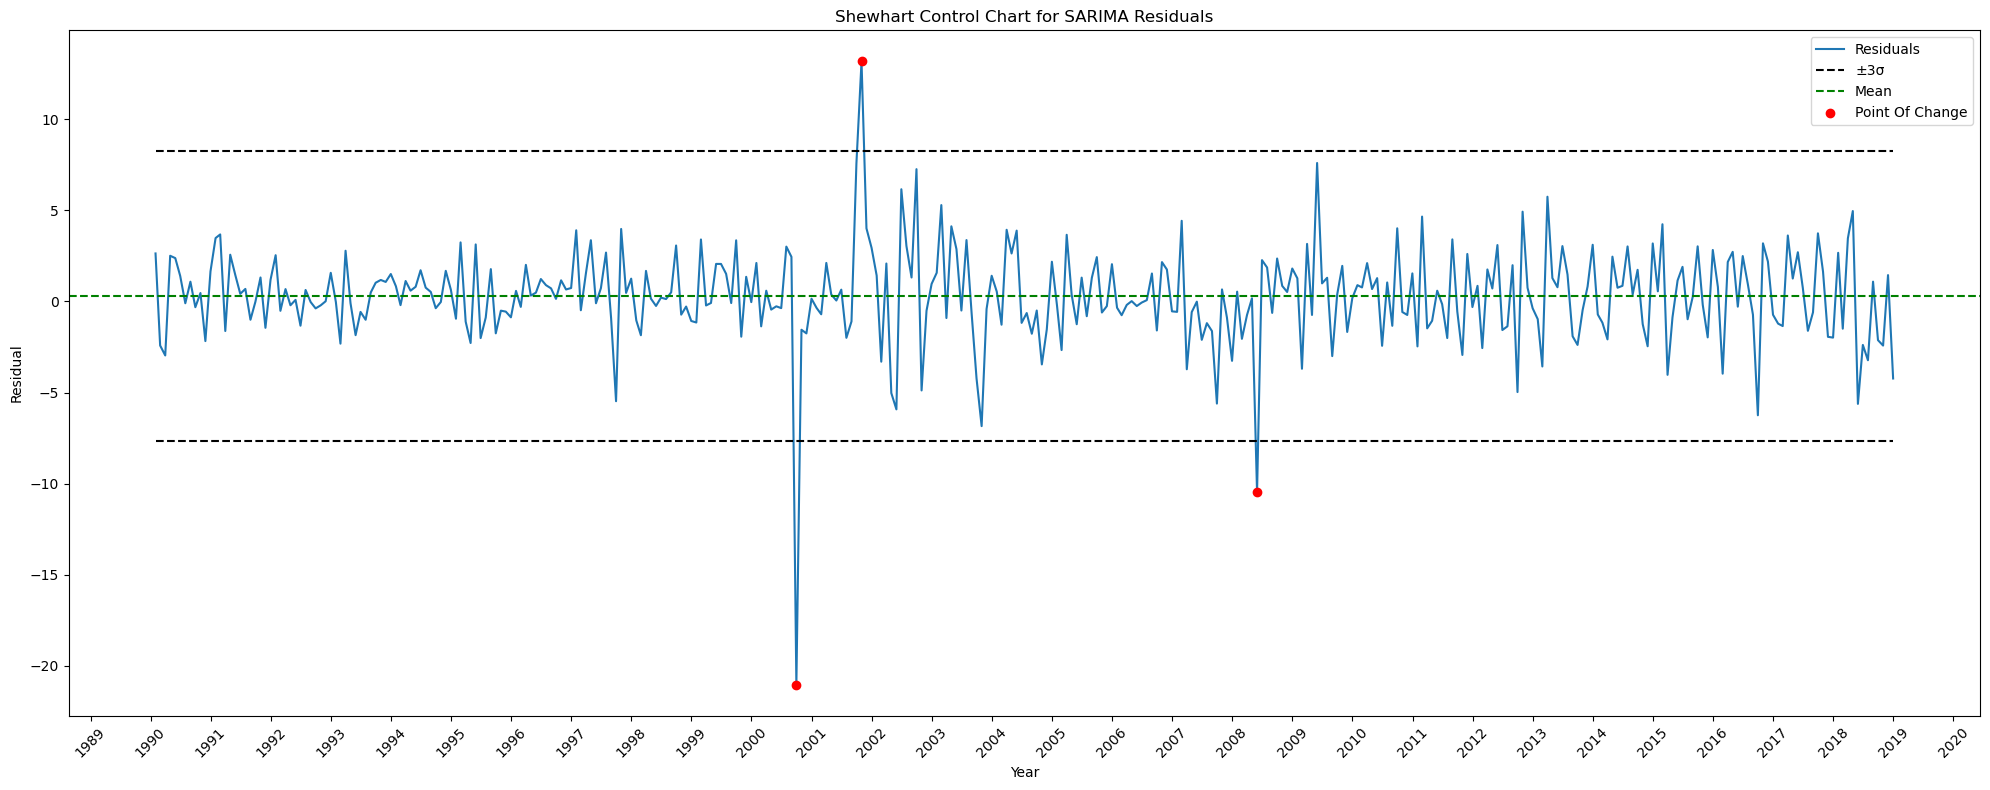

In [83]:
# Create DataFrame with residuals and ensure datetime index
res_plot = pd.DataFrame(model_AR2s.resid.iloc[12:], columns=['error'])

# If the model index is not datetime, convert it manually
if not isinstance(res_plot.index, pd.DatetimeIndex):
    res_plot.index = pd.date_range(start="1990-01-01", periods=len(res_plot), freq='ME')  # <-- adjust start date as needed

res_plot['date'] = res_plot.index  # Keep datetime index for plotting

# Calculate mean and standard deviation
res_mean = res_plot['error'].mean()
res_std = res_plot['error'].std()

# Define control limits
ucl = res_mean + 3 * res_std
lcl = res_mean - 3 * res_std

# Identify out-of-control points
out_of_control = res_plot[(res_plot['error'] > ucl) | (res_plot['error'] < lcl)]

print("Dates with out-of-control residuals:")
print(out_of_control.index.strftime('%m %Y'))

# Plot the Shewhart chart
plt.figure(figsize=(20, 8))
plt.plot(res_plot['date'], res_plot['error'], label='Residuals')
plt.hlines([ucl, lcl], res_plot['date'].min(), res_plot['date'].max(),
           linestyles='dashed', colors='black', label='±3σ')
plt.axhline(res_mean, color='green', linestyle='--', label='Mean')

# Highlight out-of-control points
plt.scatter(out_of_control['date'], out_of_control['error'], color='red', label='Point Of Change', zorder=5)

# Fix x-axis to show all years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title("Shewhart Control Chart for SARIMA Residuals")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Anomaly Detection Summary:
Using a Shewhart control chart on the residuals of the SARIMA model, we identified three significant outliers: September 2000, October 2001, and May 2008. While the latter two correspond to well-known external shocks (the aftermath of 9/11 and the global financial crisis), the spike in September 2000 was unexpected. This point did not stand out in earlier visualizations due to the strong overall trend and seasonality in the time series, which may have masked localized deviations. The statistical detection through residual analysis helped uncover this subtle anomaly, which might reflect a short-term disruption (e.g., labor strikes, airline regulation changes, or geopolitical tensions) that briefly affected flight activity but was not persistent enough to influence broader trends.